In [ ]:
#@title
%%html
<div style="background-color: pink;">
  Implementation of Sentiment Analysis Task using Transformers(Bert-Architecture)
</div>

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Introduction to BERT and the problem at hand

Exploratory Data Analysis and Preprocessing 

Training/Validation Split

Loading Tokenizer and Encoding our Data

Setting up BERT Pretrained Model

Creating Data Loaders

Setting Up Optimizer and Scheduler

Defining our Performance Metrics

Creating our Training Loop

Loading and Evaluating our Model

In [1]:
import torch

if torch.cuda.is_available():
  device= torch.device("cuda")
  print("There is %d gpu device available"%torch.cuda.device_count() if torch.cuda.device_count()==1 else "There are %d gpu devices available"%torch.cuda.device_count())
  print(f"Using Gpu :{torch.cuda.get_device_name(0)}")

else:
  print("Gpu device Not Found, Using Cpu Instead")

There is 1 gpu device available
Using Gpu :Tesla T4


In [2]:
!pip install transformers

     |████████████████████████████████| 2.5MB 29.4MB/s 
     |████████████████████████████████| 901kB 55.4MB/s 
     |████████████████████████████████| 3.3MB 53.8MB/s 


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import ipywidgets as widgets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
import transformers
from transformers import BertTokenizer,AutoModel, BertModel
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup
from collections import defaultdict
import random

In [15]:
df= pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [17]:
idx=[]
for i in range(20000):
  idx.append(random.randint(1,50000))

df= df.iloc[idx,:].copy()
df.reset_index(drop=True,inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'review score')

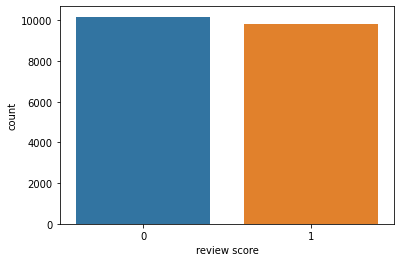

In [18]:
df["sentiment"]= pd.Series(np.where(df["sentiment"]=="positive",1,0))
#review_list= df.review.tolist()

ax= sns.countplot(df.sentiment)
plt.xlabel('review score')

Before tokenizing our text, we will perform some slight processing on our text including removing entity mentions.
The level of processing here is much less than in previous approachs because BERT was trained with the entire sentences

In [19]:
def re_preprocessing(text):
  # Isolate and remove punctuations except '?'
  text= re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', text)
  text= re.sub(r'[^\w\s\?]', ' ', text)
  
  text = re.sub(r'(@.*?)[\s]'," ",text)
  text= re.sub(r"\s+"," ",text).strip()

  return text 

df["review"]= df["review"].apply(lambda x: re_preprocessing(x))

Because we are considering the uncased model, the sentence was lowercased first.In Bert model, Word piece tokenizer is used which splits "gpu" into known subwords: ["gp" and "##u"]. "##" means that the rest of the token should be attached to the previous one, without space (for decoding or reversal of the tokenization)

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.Add special tokens to separate sentences and do classification
Pass sequences of constant length (introduce padding)
Create array of 0s (pad token) and 1s (real token) called attention mask

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 512.0)

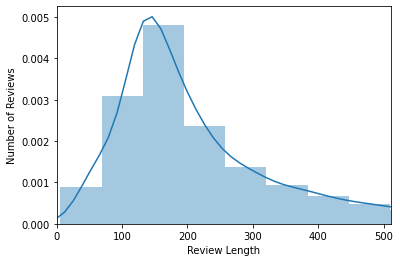

In [20]:
sns.distplot(df["review"].apply(lambda x: len(x.split())),bins=40)
plt.xlabel("Review Length")
plt.ylabel("Number of Reviews")
plt.xlim([0,512])

In [21]:
df["review"]= df["review"].apply(lambda x: " ".join(x.split()[:350]))
max_len = df["review"].apply(lambda x: len(x.split())).max()
print(max_len)

350


In [22]:
Max_Len= 350
model_name="bert-base-uncased"
tokenizer= BertTokenizer.from_pretrained(model_name,do_lower_case=True)

class Final_embedding_dataset():
  
  def __init__(self,reviews,targets,tokenizer,max_len):
    
    self.reviews= reviews
    self.targets= targets
    self.tokenizer= tokenizer
    self.max_len= max_len
    
  def __len__(self):
    return len(self.reviews)

  def __getitem__(self,item):

    review= self.reviews[item]
    target= self.targets[item]

    encoding = self.tokenizer.encode_plus(review,add_special_tokens=True, padding="max_length",truncation=True, 
                                 return_tensors="pt",verbose=False,max_length=self.max_len,return_attention_mask=True)
    
# return_tensors="pt", gives us the embedding in form of tensors.
# tensors should be flattened.
    return {"review":review,
      "input_ids":encoding["input_ids"].flatten(),
      "attention_mask":encoding["attention_mask"].flatten(),
      "target": torch.tensor(target,dtype= torch.long)}

verbose=false suggest that if the keyword argument is not consistent with the model it doesn't throw an error, instead ignore it.

Attention_mask is all about: it points out which tokens the model should pay attention to and which ones it should not (because they represent padding in this case).
token type IDs (also called segment IDs). They are represented as a binary mask identifying the two types of sequence in the model.
positions_ids is used to identify each token's position in the list of tokens
The default positional encoding is absolute(generally used in BERT), whereas some of the model us sinusodial position encoding also.

In [23]:
df_train,df_test= train_test_split(df,test_size=0.2,random_state=1)
print(df_train.shape,df_test.shape)

(16000, 2) (4000, 2)


Data Loader function from pytorch library could take in a map based dataset or a iterable dataset, i have used the map based one using the magic methods, __len__ and __getitem__ to create a map based iteratable object

In [24]:
def create_data_loader(df,batch_size,tokenizer,max_len):
  dataset= Final_embedding_dataset(df["review"].to_numpy(),df["sentiment"].to_numpy(),tokenizer,Max_Len)

  return DataLoader(dataset,batch_size=batch_size,num_workers=2)

Batch_Size= 16

train_data_loader= create_data_loader(df_train,Batch_Size,tokenizer,Max_Len)
test_data_loader= create_data_loader(df_test,Batch_Size,tokenizer,Max_Len)

In [25]:
#Experimentation:-
data= next(iter(train_data_loader))
print(data["input_ids"].shape)
print(data["attention_mask"].shape)
print(data["target"].shape)

torch.Size([16, 350])
torch.Size([16, 350])
torch.Size([16])


In [26]:
model= AutoModel.from_pretrained(model_name)
model.config.hidden_size

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


768

think of the pooled_output as a summary of the content, according to BERT.

In [27]:
class SentimentClassifier(nn.Module):
  def __init__(self,n_classes,model):
    super(SentimentClassifier,self).__init__()
    self.model = model
    self.dropout= nn.Dropout(p=0.3)
    self.output= nn.Linear(self.model.config.hidden_size,n_classes)

  def forward(self,input_ids,attention_mask):
    output= self.model(input_ids=input_ids,attention_mask=attention_mask)
    class_output= self.dropout(output["pooler_output"])

    return self.output(class_output)

In [28]:
n_classes= 2
classifier_model= SentimentClassifier(n_classes,model)
classifier_model= classifier_model.to(device)

In [29]:
EPOCHS= 10 

optimizer= AdamW(classifier_model.parameters(),lr=3e-5, correct_bias=False) # in bert actual implementation correct_bias is False
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps= len(train_data_loader)*EPOCHS) # num_steps= num_minibatch*Epoch

loss_function= nn.CrossEntropyLoss().to(device)

In [30]:
# helper function for training. Basically a function for training step- one epoch.

def train_one_epoch(model,data_loader,loss_function,optimizer,device,scheduler,n_examples):

  model= model.train()

  losses=[]
  correct_predictions= 0

  for d in data_loader:
    input_ids= d.get("input_ids").to(device)
    attention_mask= d.get("attention_mask").to(device)
    targets= d.get("target").to(device)

    outputs= model(input_ids,attention_mask)
    
    _,preds= torch.max(outputs,dim=1)
    loss= loss_function(outputs,targets)

    correct_predictions+= torch.sum(preds==targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0) # is necessary to ensure that the gradients doesn't blow up
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    
    accuracy= correct_predictions/n_examples

  return accuracy,np.mean(losses)


In [31]:
def eval_model(model,data_loader,loss_function,device,n_examples):

  model= model.eval()

  losses=[]
  correct_predictions= 0

  with torch.no_grad():
    for d in data_loader:
      input_ids= d.get("input_ids").to(device)
      attention_mask= d.get("attention_mask").to(device)
      targets= d.get("target").to(device)
     
      outputs= model(input_ids,attention_mask)
    
      _,preds= torch.max(outputs,dim=1)
      loss= loss_function(outputs,targets)

      correct_predictions+= torch.sum(preds==targets)
      losses.append(loss.item())
    
      accuracy= correct_predictions.double()/n_examples

  return accuracy,np.mean(losses)


In [ ]:
#call model using classifier_model
# writing the training loop

history=defaultdict(list)
best_accuracy=0

for epoch in range(EPOCHS):
  print(f"EPOCH: {epoch+1}/{EPOCHS}")
  print("---"*10)

  train_acc,train_loss= train_one_epoch(classifier_model,train_data_loader,loss_function,optimizer,device,scheduler,len(df_train))
 
  print(f"Accuracy: {train_acc} Train loss: {train_loss}")
  
  test_acc, test_loss = eval_model(classifier_model,test_data_loader,loss_function,device, len(df_test) )

  print(f"test_accuracy: {test_acc} Test loss: {test_loss}")

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  # if test_acc> best_accuracy:
  #   torch.save(model.state_dict(),"best_model_state.bin")
  #   best_accuracy= test_acc

torch.save(model.state_dict(),"model.bin")

In [ ]:
plt.plot(np.arange(EPOCHS),history["train_acc"],label="train_accuracy")
plt.plot(np.arange(EPOCHS),history["test_acc"],label="test_accuracy")

plt.xlabel("EPOCHS")
plt.ylabel("Accuracy")
plt.title("Accuracy Plot")
plt.ylim([0,1])
plt.show()

In [ ]:
def get_predictions(model,data_loader):

  model= model.eval()

  review_text= []
  predictions= []
  prediction_probs= []
  target_values= []

  with torch.no_grad():
    for d in data_loader:
      input_ids= d.get("input_ids").to(device)
      attention_mask= d.get("attention_mask").to(device)
      targets= d.get("target").to(device)

      outputs= model(input_ids,attention_mask)
    
      _,preds= torch.max(outputs,dim=1)
      probs= F.softmax(outputs,dim=1)

      review_text.append(d["review_text"]).cpu()
      predictions.append(preds).cpu()
      prediction_probs.append(probs).cpu()
      target_values.append(targets).cpu()
      

  return review_text, predictions, prediction_probs, target_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_data_loader)

In [ ]:
classification_report(y_test,y_pred)

In [ ]:
# Get predictions from the probabilities
# threshold = 0.9
# preds = np.where(probs[:, 1] > threshold, 1, 0)

In [ ]:
# A widget to select among the transformers model to use.
# Model= widgets.Dropdown(
#     options=["Bert","RobertA","DistilBert"],
#     value="model",
#     description="Model to input",
#     disabled=False)

# Input= widgest.Text(value="",placeholder="Enter Something",description="Input Text",disabled=False)

# def sentiment_check():
#   if Model=="Bert":
#     output= 
#     print(f"The sentiment score is: {output}")

# input.on_submit(sentiment_check)
# display(Model,Input)